In [1]:
import time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy

## Data

In [2]:
num_train_points = 500
num_test_points = 100
num_runs = 10

In [3]:
data = np.load("../output/synthetic_data.npz")

train_x=data["train_x"]
train_y=data["train_y"]
test_x=data["test_x"]
test_y=data["test_y"]
low_noise_xs=data["low_noise_xs"]
high_noise_xs=data["high_noise_xs"]

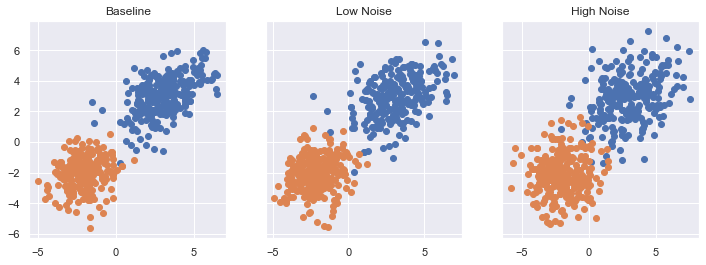

In [4]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

class0 = train_y[:, 0] == 0
class1 = train_y[:, 0] == 1

train_xs = [train_x, low_noise_xs[0], high_noise_xs[0]]
labels = ["Baseline", "Low Noise", "High Noise"]

for i in range(3):
    axs[i].set_title(labels[i])
    axs[i].scatter(train_xs[i][class0, 0], train_xs[i][class0, 1])
    axs[i].scatter(train_xs[i][class1, 0], train_xs[i][class1, 1])

In [5]:
baseline_scores = np.load("../output/synthetic_baseline_scores.npz")
low_noise_scores = np.load("../output/synthetic_low_noise_scores.npz")
high_noise_scores = np.load("../output/synthetic_high_noise_scores.npz")

## Lipschitz Distance of Training Points

### Global

In [6]:
methods = ["influence", "relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_idx = np.argsort(np.sum(baseline_scores[methods[i]], axis=1))[-1]
    
    low_noise_idxs = np.argsort(np.sum(low_noise_scores[methods[i]], axis=2), axis=1)[:, -1]
    high_noise_idxs = np.argsort(np.sum(high_noise_scores[methods[i]], axis=2), axis=1)[:, -1]  

    
    low_noise_dists = [
        np.linalg.norm(low_noise_xs[k, low_noise_idxs[k]] - train_x[baseline_idx])
        / np.linalg.norm(low_noise_xs[k] - train_x)
        for k in range(num_runs)
    ]
    
    high_noise_dists = [
        np.linalg.norm(high_noise_xs[k, high_noise_idxs[k]] - train_x[baseline_idx])
        / np.linalg.norm(high_noise_xs[k] - train_x)
        for k in range(num_runs)
    ]
    
    print("{:>3}: Low Noise={:.3f} \pm {:.3f}, High Noise={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(low_noise_dists),
        np.std(low_noise_dists),
        np.mean(high_noise_dists),
        np.std(high_noise_dists),
    ))

 IF: Low Noise=0.036 \pm 0.013, High Noise=0.074 \pm 0.076
RIF: Low Noise=0.261 \pm 0.227, High Noise=0.168 \pm 0.107
 GC: Low Noise=0.289 \pm 0.206, High Noise=0.137 \pm 0.106
 RP: Low Noise=0.067 \pm 0.063, High Noise=0.071 \pm 0.029


### Local

In [7]:
methods = ["influence", "relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_idxs = np.argsort(baseline_scores[methods[i]], axis=0)[-1]
    
    low_noise_idxs = np.argsort(low_noise_scores[methods[i]], axis=1)[:, -1, :]
    high_noise_idxs = np.argsort(high_noise_scores[methods[i]], axis=1)[:, -1, :]
        
    low_noise_dists = [
        np.linalg.norm(low_noise_xs[k, low_noise_idxs[k]] - train_x[baseline_idxs], axis=1)
        / np.linalg.norm(low_noise_xs[k] - train_x)
        for k in range(num_runs)
    ]
    
    high_noise_dists = [
        np.linalg.norm(high_noise_xs[k, high_noise_idxs[k]] - train_x[baseline_idxs], axis=1)
        / np.linalg.norm(high_noise_xs[k] - train_x)
        for k in range(num_runs)
    ]
    
    print("{:>3}: Low Noise={:.3f} \pm {:.3f}, High Noise={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(low_noise_dists),
        np.std(low_noise_dists),
        np.mean(high_noise_dists),
        np.std(high_noise_dists),
    ))

 IF: Low Noise=0.112 \pm 0.101, High Noise=0.098 \pm 0.063
RIF: Low Noise=0.250 \pm 0.198, High Noise=0.126 \pm 0.101
 GC: Low Noise=0.234 \pm 0.190, High Noise=0.122 \pm 0.095
 RP: Low Noise=0.088 \pm 0.096, High Noise=0.087 \pm 0.061


## Rank Correlation

### Global

In [8]:
methods = ["influence", "relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_vals = np.sum(baseline_scores[methods[i]], axis=1)
    
    low_noise_vals = np.sum(low_noise_scores[methods[i]], axis=2)
    high_noise_vals = np.sum(high_noise_scores[methods[i]], axis=2)

    low_noise_rs = [scipy.stats.spearmanr(baseline_vals, low_noise_vals[k]).correlation for k in range(num_runs)]
    high_noise_rs = [scipy.stats.spearmanr(baseline_vals, low_noise_vals[k]).correlation for k in range(num_runs)]
    
    print("{:>3}: Low Noise={:.3f} \pm {:.3f}, High Noise={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(low_noise_rs),
        np.std(low_noise_rs),
        np.mean(high_noise_rs),
        np.std(high_noise_rs),
    ))

 IF: Low Noise=0.908 \pm 0.009, High Noise=0.908 \pm 0.009
RIF: Low Noise=0.718 \pm 0.026, High Noise=0.718 \pm 0.026
 GC: Low Noise=0.733 \pm 0.030, High Noise=0.733 \pm 0.030
 RP: Low Noise=0.917 \pm 0.014, High Noise=0.917 \pm 0.014


### Local

In [9]:
methods = ["influence", "relatif", "grad_cos", "representer_values"]
labels = ["IF", "RIF", "GC", "RP"]

for i in range(4):
    
    baseline_vals = baseline_scores[methods[i]].T
    
    low_noise_vals = low_noise_scores[methods[i]].transpose((0, 2, 1))
    high_noise_vals = high_noise_scores[methods[i]].transpose((0, 2, 1))

    low_noise_rs = [[scipy.stats.spearmanr(baseline_vals[j], low_noise_vals[k, j]).correlation for j in range(num_test_points)] for k in range(num_runs)]
    high_noise_rs = [[scipy.stats.spearmanr(baseline_vals[j], low_noise_vals[k, j]).correlation for j in range(num_test_points)] for k in range(num_runs)]
    
    print("{:>3}: Low Noise={:.3f} \pm {:.3f}, High Noise={:.3f} \pm {:.3f}".format(
        labels[i],
        np.mean(low_noise_rs),
        np.std(low_noise_rs),
        np.mean(high_noise_rs),
        np.std(high_noise_rs),
    ))

 IF: Low Noise=0.875 \pm 0.041, High Noise=0.875 \pm 0.041
RIF: Low Noise=0.740 \pm 0.042, High Noise=0.740 \pm 0.042
 GC: Low Noise=0.768 \pm 0.049, High Noise=0.768 \pm 0.049
 RP: Low Noise=0.912 \pm 0.019, High Noise=0.912 \pm 0.019
